In [112]:
# Imports
import numpy as np
import pandas as pd
import importlib as imp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score

In [113]:
# User module imports
from utils import district_daily_data as dd
dd = imp.reload(dd)

In [114]:
# Flags
linear_reg = False
sv_reg = True
episodes = True

In [115]:
# Directory variables
data_dir = 'data/'

In [116]:
# Read state data
df_state = pd.read_csv(data_dir + 'state-date-total-data.csv')
arr_state = df_state.to_numpy() # still reversed
arr_state = np.flipud(arr_state) # now taken data from day-1 to day-52; but still daily cases
arr_state = np.cumsum(arr_state, axis=0) # now cumulative cases till day 52
np.savetxt(data_dir + 'state-date-total-data-cumulative.csv', arr_state.astype(int), fmt='%i', delimiter=",")

In [117]:
# Read population density data
df_population_density = pd.read_csv(data_dir + 'district_wise_population_density.csv')
np_population_density = df_population_density.to_numpy() 
data_found_count = 0 # no of districts for which we have population density data

def get_district_population_density(d):
    global data_found_count
    dist_pop_density = -2
    for i_cn in range(len(np_population_density)):
        if(np_population_density[i_cn][1].lower().count(d.lower().strip()) > 0):
            dist_pop_density = max(float(np_population_density[i_cn][7]), dist_pop_density)
    if(dist_pop_density <= 0): # print(d) # district not matched || area not found || population data missing
        dist_pop_density = 368 # population density of INDIA
    else:
        data_found_count = data_found_count + 1
    return dist_pop_density



In [118]:
# Read district data
districts = dd.get_all_districts()
dist_series = []  # [(start_date, series), (start_date, series), ...]

# Note: start_date might itself be a feature
for d in districts:
    d_start_date = dd.get_infection_start(d)
    district_pop_density = get_district_population_density(d)
    dist_series.append((d_start_date, dd.get_district_time_series(d, d_start_date), district_pop_density))

print("data_found_count:", data_found_count,  " tot dists:", len(districts))

data_found_count: 1  tot dists: 459


In [119]:
dist_series

[('14/03/2020',
  [1,
   0,
   3,
   1,
   1,
   4,
   2,
   11,
   1,
   17,
   0,
   9,
   0,
   6,
   20,
   9,
   4,
   62,
   29,
   55,
   43,
   76,
   104,
   68,
   116,
   74,
   93,
   205,
   132,
   152,
   242,
   216,
   140,
   177,
   12,
   183,
   459,
   306,
   420,
   238,
   517,
   239,
   602,
   358,
   369,
   393,
   475,
   417,
   751,
   547,
   0,
   0],
  20924.84529)]

In [120]:
if linear_reg:
    # Get x and y plots - LinearRegression
    X = np.arange(1,53)
    X = np.reshape(X, (52,1))
    print (arr_state.shape)

    for i in range(len(arr_state[0])):
        y = arr_state[:,i]
        y = np.reshape(y, (52,1))
        reg = LinearRegression().fit(X, y)
        x_test = np.arange(1,56).reshape(55,1)
        y_test = reg.predict(x_test)
        plt.scatter(X, y, color='black')
        plt.plot(x_test,y_test)
        plt.show()

In [121]:
if sv_reg and not episodes:
    # Get x and y plots - SVRegression
    X = np.arange(1,53)
    X = np.reshape(X, (52,1))

    for i in range(len(arr_state[0])):
        y = arr_state[:,i]
        x_test = np.arange(1,56).reshape(55,1)
        clf = SVR(C=100.0, gamma=100)
        clf.fit(X, y)
        y_test = clf.predict(x_test)

        plt.scatter(X, y, color='black')
        plt.plot(x_test,y_test)
        plt.show()

38


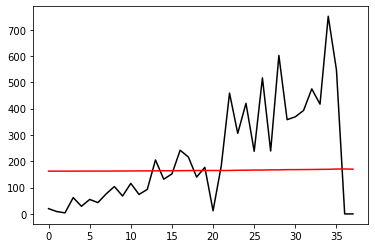

In [122]:
if episodes:
    # Construct train and test data and fit Support Vector Regression
    x = []
    y = []
    episode_length = 14
    count = 0
    for tup in dist_series:
        series = tup[1]
        dist_pop_density = tup[2]
#         print (len(series))
        num_episodes = len(series) - episode_length + 1
        if num_episodes < 2: continue
#         print (num_episodes)
        for _in in range(num_episodes-1):
            x.append([dist_pop_density] + series[_in:_in+episode_length])
            y.append(series[_in+episode_length])
    print (len(x))
    x = np.array(x)
    y = np.array(y)

    train_length = int(0.8*len(x))
    x_train = x[:train_length]
    y_train = y[:train_length]
    x_test = x[train_length:]
    y_true = y[train_length:]
    clf = SVR(C=100.0, gamma='scale')
    clf.fit(x, y)
    
    y_test = clf.predict(x)
    X = np.arange(len(y))
    X = np.reshape(X, (len(y), 1))
    
    # Test
    # y_test = clf.predict(x_test)
    # X = np.arange(len(y_test))
    # X = np.reshape(X, (len(y_test), 1))
    plt.plot(X, y, color='black')
    plt.plot(X, y_test, color='red')

In [123]:
print (x_train[0])

[2.09248453e+04 1.00000000e+00 0.00000000e+00 3.00000000e+00
 1.00000000e+00 1.00000000e+00 4.00000000e+00 2.00000000e+00
 1.10000000e+01 1.00000000e+00 1.70000000e+01 0.00000000e+00
 9.00000000e+00 0.00000000e+00 6.00000000e+00]
